## Trajectory Optimization with Differentiable Physics

### Imports

In [1]:
from copy import deepcopy
# math
import numpy as np
# optim
import torch
# physics
import warp as wp
import warp.sim as wps
# graphics
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as mit
# plots
from matplotlib import pyplot as plt

# setup
wp.init()
mi.set_variant('llvm_ad_rgb')
print(f'Mitsuba 3 Variant: {mi.variant()}')

Warp 0.15.1 initialized:
   CUDA Toolkit 11.5, Driver 11.4
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce GTX 1050 Ti with Max-Q Design" (4 GiB, sm_61, mempool enabled)
   Kernel cache:
     /home/jonathan/.cache/warp/0.15.1
Mitsuba 3 Variant: llvm_ad_rgb


### Scene

In [2]:
# camera positioned to view the scene, adjust as needed
cam_pos = np.array([0.0, 1.0, 5.0])  
cam_target = np.array([0.0, 1.0, 0.0])
cam_up = np.array([0.0, 1.0, 0.0])

# particle
particle_init_pos = np.array([-0.5, 1.0, 0.0])
particle_init_vel = np.array([5.0, -5.0, 0.0])
particle_radius = 0.2
particle_mass = 1.0
particle_rgb = np.array([0.2, 0.25, 0.7])

# wall
wall_pos = np.array([2.0, 1.0, 0.0])
wall_extents = np.array([0.25, 1.0, 1.0])
wall_rgb = np.array([0.7, 0.25, 0.2])

# target
target_pos = np.array([-2.0, 1.5, 0.0])

# contact parameters
ke = 1.0e4
kf = 0.0
kd = 1.0e1
mu = 0.2
rt = 1.0
margin = 10.0

# simulation parameters
sim_duration = 0.6
# control frequency
fps = 60
frame_dt = 1.0 / float(fps)
frame_steps = int(sim_duration / frame_dt)
# sim frequency
sim_substeps = 8
sim_steps = frame_steps * sim_substeps
sim_dt = frame_dt / sim_substeps

### Physics

In [3]:
def build_phys(device):
    builder = wps.ModelBuilder()
    # particle
    builder.add_particle(pos=particle_init_pos, vel=particle_init_vel, radius=particle_radius, mass=particle_mass)
    # wall
    builder.add_shape_box(body=-1, 
                          pos=wall_pos, 
                          hx=wall_extents[0], hy=wall_extents[1], hz=wall_extents[2], 
                          ke=ke, kf=kf, kd=kd, mu=mu)
    model = builder.finalize(device, requires_grad=True)

    # ground
    model.soft_contact_kf = kf
    model.soft_contact_margin = margin

    # allocate sim states for trajectory
    states = [model.state(requires_grad=True) for _ in range(sim_steps + 1)]

    # one-shot contact creation
    wp.sim.collide(model, states[0])

    return model, states


def capture_phys(device, model, integrator, states):
    # tape tracks computation graph
    tape = wp.Tape()
    wp.capture_begin(device=device)
    with tape:
        for i in range(sim_steps):
            states[i].clear_forces()
            integrator.simulate(model, states[i], states[i + 1], sim_dt)
    graph = wp.capture_end()

    return graph, tape


def get_trajectory(states):
    trajectory = []
    for state in states[::sim_substeps]:
        trajectory.append(state.particle_q.numpy().squeeze())
    return np.array(trajectory)

### Rendering

In [4]:
img_width = 256
img_height = 256
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': particle_radius,
        'bsdf': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': particle_rgb
            }
        }
    },
    'wall': {
        'type': 'cube',
        'to_world': mit.translate(wall_pos).scale(wall_extents),
        'bsdf' : {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': wall_rgb
            }
        }
    },
    "ground": {
        "type": "rectangle",
        "to_world": mit.rotate(axis=[1.0, 0.0, 0.0], angle=-90).scale(20),
        "bsdf": {
            "type": "diffuse",
            'reflectance': {
                'type': 'checkerboard',
                'to_uv': mi.ScalarTransform4f.scale([10, 10, 1])
            }
        }
    }
}

### States

In [5]:
# initial run 
phys_device = wp.get_cuda_devices()[0]
phys_model, phys_states = build_phys(phys_device)
phys_integrator = wp.sim.SemiImplicitIntegrator()
phys_graph, phys_tape = capture_phys(phys_device, phys_model, phys_integrator, phys_states)
wp.capture_launch(phys_graph)

pred_state = phys_states[-1].particle_q.numpy()

Module warp.sim.collide load on device 'cuda:0' took 202.22 ms
Module warp.utils load on device 'cuda:0' took 6.13 ms
Module warp.sim.inertia load on device 'cuda:0' took 18.68 ms
Module warp.sim.model load on device 'cuda:0' took 0.26 ms
Module warp.sim.optimizer load on device 'cuda:0' took 1.77 ms
Module warp.sim.particles load on device 'cuda:0' took 5.71 ms
Module warp.sim.utils load on device 'cuda:0' took 18.95 ms
Module warp.sim.integrator_euler load on device 'cuda:0' took 78.28 ms
Module warp.sim.integrator_xpbd load on device 'cuda:0' took 130.62 ms
Module warp.sim.articulation load on device 'cuda:0' took 42.76 ms


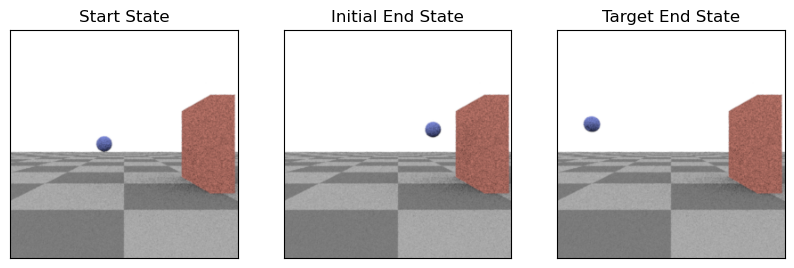

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(10, 5))

init_start_scene_dict = dict(scene_dict)
init_start_scene_dict['particle']['center'] = deepcopy(particle_init_pos)
bitmap_init = mi.util.convert_to_bitmap( mi.render(mi.load_dict(init_start_scene_dict), spp=16))
axs[0].imshow(bitmap_init)
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Start State')


init_end_scene_dict = dict(scene_dict)
init_end_scene_dict['particle']['center'] = deepcopy(pred_state)
bitmap_init = mi.util.convert_to_bitmap( mi.render(mi.load_dict(init_end_scene_dict), spp=16))
axs[1].imshow(bitmap_init)
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Initial End State')


target_scene_dict = dict(scene_dict)
target_scene_dict['particle']['center'] = deepcopy(target_pos)
bitmap_target = mi.util.convert_to_bitmap(mi.render(mi.load_dict(target_scene_dict), spp=16))
axs[2].imshow(bitmap_target)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Target End State')

plt.show()
#plt.savefig('fig_direct_traj_states.pdf', bbox_inches='tight')

### Optimization

In [7]:
# training details
train_iters = 4
train_rate = 1.0
train_save_interval = 2

# physics
phys_device = wp.get_cuda_devices()[0]
phys_model, phys_states = build_phys(phys_device)
phys_integrator = wp.sim.SemiImplicitIntegrator()
phys_graph, phys_tape = capture_phys(phys_device, phys_model, phys_integrator, phys_states)

# variables
x = wp.to_torch(phys_states[0].particle_qd)
pred = wp.to_torch(phys_states[-1].particle_q)
target = torch.tensor(target_pos, dtype=torch.float32, device=torch.device('cuda')).unsqueeze(0)

# optimization
opt = torch.optim.SGD([x], lr=train_rate)
loss = torch.nn.MSELoss(reduction='sum')

# metrics
trajs = []
losses = []

for i in range(train_iters+1):
    # zero grads
    opt.zero_grad(set_to_none=False)
    phys_tape.zero()

    # forward pass
    wp.capture_launch(phys_graph)
    output = loss(pred, target)

    if i < train_iters:  
        # backprop
        output.backward()
        phys_tape.backward(grads={pred : pred.grad})
        opt.step()

    losses.append(output.cpu().detach().numpy())
    if i % train_save_interval == 0:
        print(f"iter_{i:02d}: pose_loss={losses[-1]:6f}, end_pose=[{pred[0,0]:.4f}, {pred[0,1]:.4f}]")
        trajs.append(get_trajectory(phys_states))

iter_00: pose_loss=8.347383, end_pose=[0.8860, 1.3641]
iter_02: pose_loss=0.003488, end_pose=[-1.9699, 1.4492]
iter_04: pose_loss=0.001438, end_pose=[-1.9625, 1.4943]


### Results

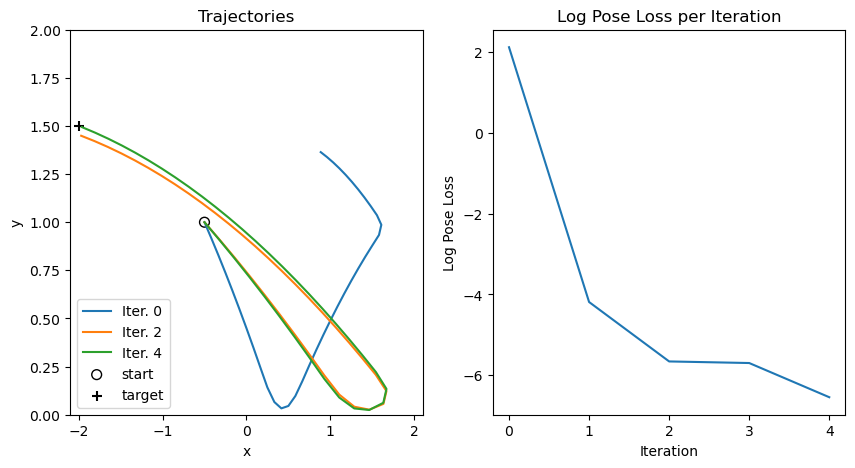

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

################
# Trajectories #
################

axs[0].set_title('Trajectories') 
for i, vel_traj in enumerate(trajs):
    axs[0].plot(vel_traj[:, 0], vel_traj[:, 1], label=f'Iter. {i*train_save_interval}')
axs[0].scatter(particle_init_pos[0], particle_init_pos[1], label='start', facecolors='none', edgecolors='black', s=50)
axs[0].scatter(target_pos[0], target_pos[1], color='black', label='target', marker='+', s=50)
axs[0].set_xlim([-2.1, 2.1])
axs[0].set_ylim([0.0, 2.0])
axs[0].set_xlabel('x');
axs[0].set_ylabel('y');
axs[0].legend(loc='lower left' )


##########
# Losses #
##########

axs[1].plot(np.log(losses))
axs[1].set_xlabel('Iteration'); 
axs[1].set_ylabel('Log Pose Loss'); 
axs[1].set_title('Log Pose Loss per Iteration')

plt.show()
#plt.savefig('fig_direct_traj_optim.pdf', bbox_inches='tight')